# Source Code 1.1)

In [34]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

### Load Data

In [35]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

print(f'train_x.shape : {train_x.shape}')
print(f'test_x.shape : {test_x.shape}')

train_x.shape : (50000, 32, 32, 3)
test_x.shape : (10000, 32, 32, 3)


In [36]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


### Data Proprecessing

In [37]:
train_x = (train_x - 127.5) / 127.5
test_x = (test_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


- -1 에서 1 사이의 값으로 정규화해주었습니다.

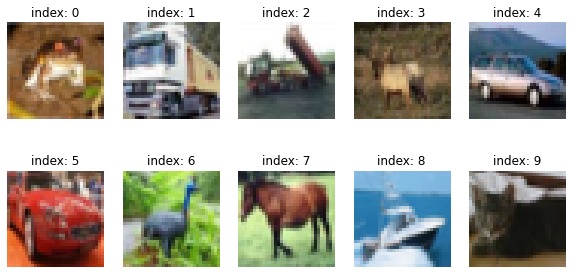

In [38]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] + 1) / 2.0)
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

- load image 10 개를 확인해보았습니다.

In [39]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

- data 를 shuffling 하고 batch 로 잘라 Dataset 으로 만들어주었습니다.

### Generator Modeling

In [40]:
def make_generator_model(momentum=0.8, alpha=0.2):

    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [41]:
generator = make_generator_model()

generator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_17 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8, 8, 256)        

- 생성자 모델을 설계하였습니다.
- generator 로 모델을 생성해주었습니다.
- 모델의 Output 벡터 shape 이 입력 데이터 shape 인 (32, 32, 3) 으로 동일합니다.

generated_image.shape : (1, 32, 32, 3)


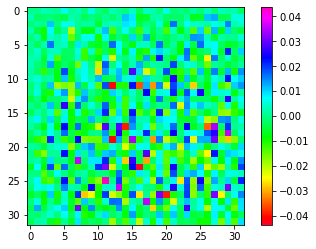

In [42]:
# Test
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(f'generated_image.shape : {generated_image.shape}')

plt.imshow(generated_image[0, :, :, 0], cmap='gist_rainbow')
plt.colorbar()
plt.show()

- (1, 100) 의 노이즈 벡터를 생성해 모델에 넣고 결과를 확인해보았습니다.
- generated_image 의 shape 도 (1, 32, 32, 3) 으로 올바르게 출력되었습니다.

### Discriminator Modeling

In [43]:
def make_discriminator_model(momentum=0.8, alpha=0.2):

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

In [44]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
batch_normalization_20 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
batch_normalization_21 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 8, 128)        

- 판별자 모델을 설계하였습니다.
- discriminator 로 모델을 생성해주었습니다.
- 모델의 Output 벡터는 **'각 이미지별 진짜라고 생각하는 정도값'** 입니다.

In [45]:
# Test
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00091099]], dtype=float32)>

- 앞서 생성한 노이즈 벡터를 판별자에 넣고 결과를 확인해보았습니다.

### Generator Loss

- Real Image 의 라벨 : 1
- Fake Image 의 라벨 : 0

In [46]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

- Generator 는 생성해내는 모든 이미지가 Real Image 의 라벨인 1 과 가까워야 합니다.
- 따라서, 생성해낸 이미지와 shape 이 같은 1 로 채워진 벡터와 비교합니다.

### Discriminator Loss

In [48]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

- Discriminator 는 Real Image 는 1 에 가깝게, Fake Image 는 0 에 가깝게 판별해내야 합니다.
- 따라서, Real Image 는 동일한 shape 의 1 로 채워진 벡터와 비교하여 loss 를 구하고
- Fake Image 는 동일한 shape 의 0 으로 채워진 벡터와 비교하여 loss 를 구합니다.
- 두 loss 를 더한 total_loss 를 줄여나가는 것이 목표입니다.

### Discriminator Accuracy

In [49]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

- Discriminator 가 Real Image 와 Fake Image 에 대해 얼마나 잘 판별하고 있는지에 대한 Accuracy 입니다.

### Optimizer

In [50]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [51]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### Train step Modeling

In [52]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output,
                                                              fake_output)
        
    grad_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(grad_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(grad_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

- 배치 당 진행될 train step 을 정의해주었습니다.
- 한 배치사이즈의 노이즈 데이터를 생성
- 판별자로 각 데이터를 판별
- 판별된 값으로 loss 와 accuracy 계산
- 구해낸 loss 로 gradient 계산
- gradient 를 optimizer 에 입력해 가중치 갱신
- loss 와 accuracy 리턴

### Util Function

In [53]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        predictions[i]
        plt.imshow((predictions[i] + 1) / 2.0)
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(os.getenv('HOME'), epoch, it))
    
    plt.show()

- 학습 현황을 확인할 수 있는 샘플 생성 함수입니다.

In [54]:
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                .format(os.getenv('HOME'), epoch))
    
    plt.show()

- train_step 이 리턴하는 loss 와 accuracy 값을 시각화하는 함수입니다.

In [55]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training

In [57]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 100 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time() - epoch_start)))
                
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time() - start)))
        
        draw_train_history(history, epoch)

- train_step(), generate_and_save_images(), draw_train_history(), checkpoint 를 모두 합쳐 training() 함수를 정의해주었습니다.

In [58]:
save_every = 5
EPOCHS = 100

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

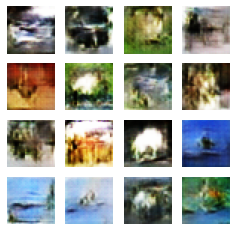

Time for training : 3205 sec


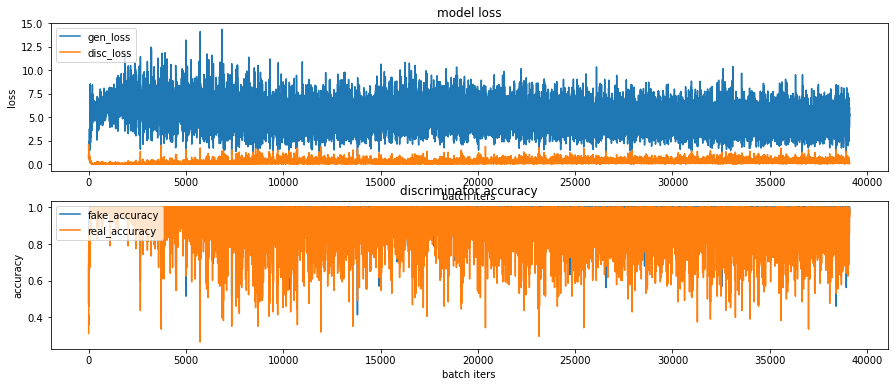

CPU times: user 54min 16s, sys: 2min 46s, total: 57min 3s
Wall time: 53min 28s


In [59]:
%%time
train(train_dataset, EPOCHS, save_every)

# Source Code 1.1) 추가 학습

In [99]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

- 앞선 모델의 학습이 부족하다고 생각되어 추가학습을 진행시켜주겠습니다.
- 마지막으로 학습된 모델을 checkpoint 에서 불러옵니다.

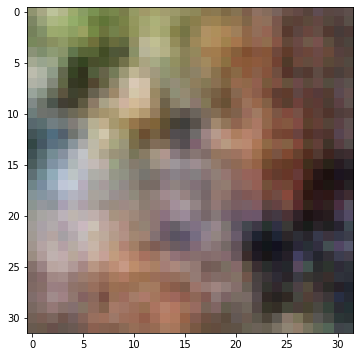

In [113]:
# Test
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5
np_generated = np_generated.astype(int)

plt.imshow(np_generated[0])
plt.show()

- 불러온 모델이 정상적으로 학습이 진행되었는지 확인합니다.

In [114]:
save_every = 5
EPOCHS = 100

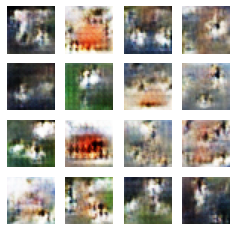

Time for training : 1534 sec


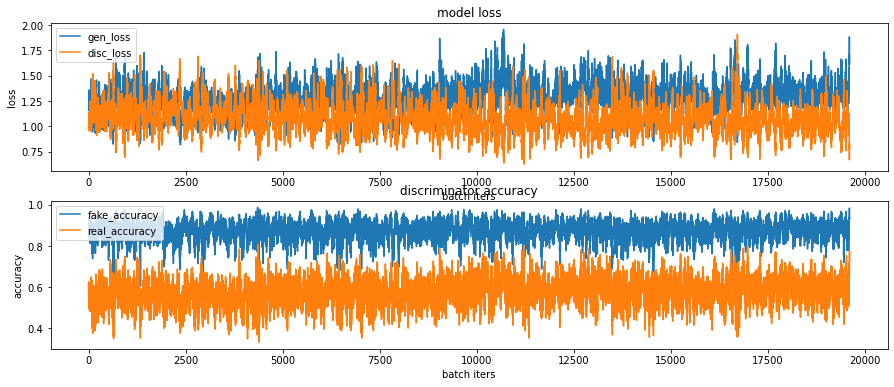

CPU times: user 26min 20s, sys: 2min 32s, total: 28min 53s
Wall time: 25min 36s


In [115]:
%%time
train(train_dataset, EPOCHS, save_every)